In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from torchvision import transforms, datasets
from torch import nn, optim
import torch.nn.functional as F

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
torch.set_printoptions(sci_mode=False)

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!


In [0]:
image, label = iter(trainloader).next()
image = image.view(image.shape[0],-1)
image.shape
label.shape

In [0]:
# model = nn.Sequential(nn.Linear(784, 256),
#                       nn.ReLU(),
#                       nn.Linear(256,128),
#                       nn.ReLU(),
#                       nn.Linear(128,10),
#                       nn.LogSoftmax(dim=1))

class Classifer(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

model = Classifer()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [5]:
epochs = 30
train_losses, test_losses = [], []
model.cuda()

for e in range(epochs):
    train_loss = 0
    model.train()
    for image, label in trainloader:
        image, label = image.cuda(), label.cuda()
        image = image.view(image.shape[0],-1)
        
        optimizer.zero_grad()
        
        output = model(image)
        loss = criterion(output, label)
        train_loss += loss
        
        loss.backward()
        optimizer.step()
    else:
        test_loss = 0
        acc = 0
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                images, labels = images.cuda(), labels.cuda()
                log_ps = model(images.view(images.shape[0],-1))
                ps = torch.exp(log_ps)
                test_loss += criterion(log_ps, labels)
                top_p, top_class = ps.topk(1, dim=1)

                equals = top_class == labels.view(top_class.shape)
                acc += torch.mean(equals.type(torch.FloatTensor))

        train_losses.append(float(train_loss/len(trainloader)))
        test_losses.append(float(test_loss/len(testloader)))

        print("epoch - ", e+1 ," | train loss - ", float(train_loss/len(trainloader)))
        print("accuracy -", float(acc*100/len(testloader))," | test loss - ", float(test_loss/len(testloader)) ,"\n")

epoch -  1  | train loss -  0.6030734181404114
accuracy - 82.68312072753906  | test loss -  0.4895201325416565 

epoch -  2  | train loss -  0.48240357637405396
accuracy - 83.72810363769531  | test loss -  0.44574958086013794 

epoch -  3  | train loss -  0.4526279866695404
accuracy - 84.6536636352539  | test loss -  0.4304116666316986 

epoch -  4  | train loss -  0.4329519271850586
accuracy - 84.52428436279297  | test loss -  0.453121542930603 

epoch -  5  | train loss -  0.4260278344154358
accuracy - 85.59912109375  | test loss -  0.4025450348854065 

epoch -  6  | train loss -  0.4138107895851135
accuracy - 85.32046508789062  | test loss -  0.41134732961654663 

epoch -  7  | train loss -  0.4012664556503296
accuracy - 86.37539672851562  | test loss -  0.39267387986183167 

epoch -  8  | train loss -  0.40362533926963806
accuracy - 86.53463745117188  | test loss -  0.38049888610839844 

epoch -  9  | train loss -  0.39698803424835205
accuracy - 86.37539672851562  | test loss -  0.

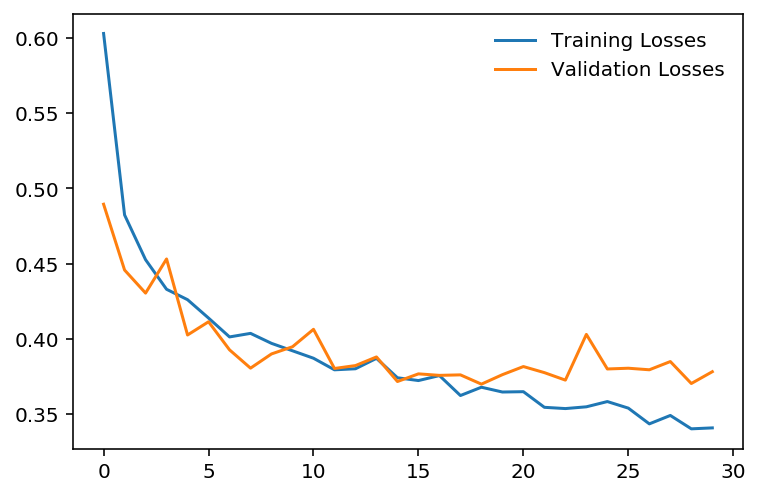

In [6]:
plt.plot(train_losses, label='Training Losses')
plt.plot(test_losses, label="Validation Losses")
plt.legend(frameon=False)

In [0]:
# Save Model
torch.save(model.state_dict(), "checkpoint.pth")

# Load Model
# state_dict = torch.load("checkpoint.pth")
# model.load_state_dict(state_dict)

In [0]:
image, label = iter(testloader).next()
image = image[0].view(1,784)

with torch.no_grad():
    logps = model(image)

ps = torch.exp(logps)

label - Pullover


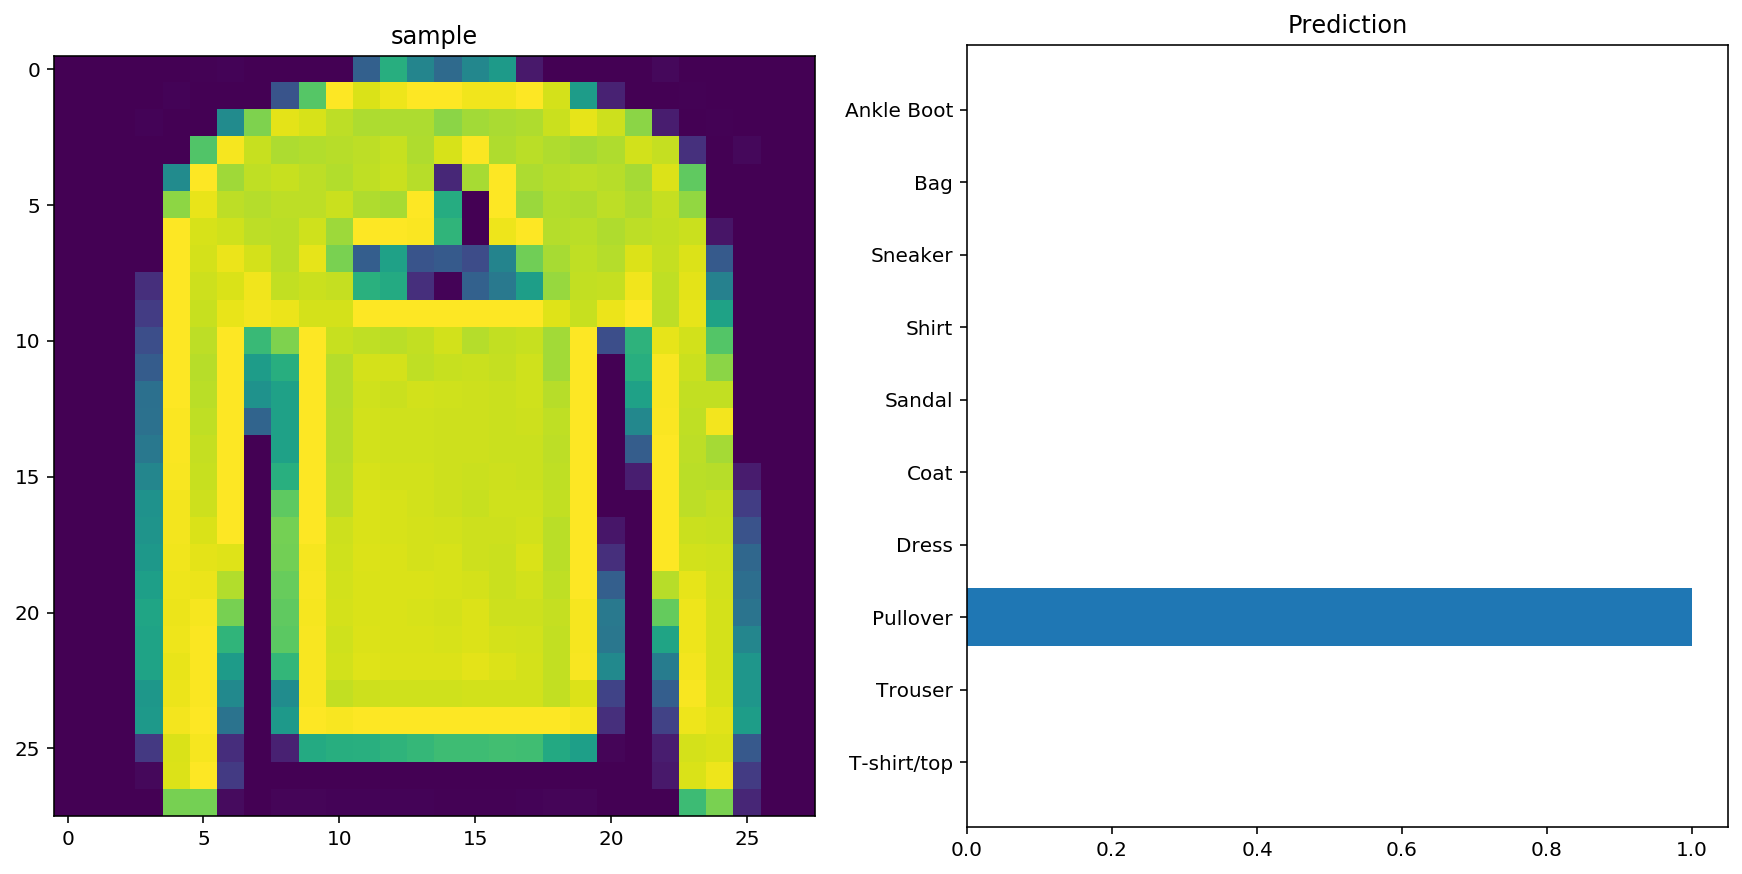

In [0]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
axs[0].set_title('sample')
axs[0].imshow(image.view(28,28).numpy().squeeze())

axs[1].set_title('Prediction')
labelnames = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
axs[1].barh(np.arange(10),ps.numpy().squeeze())
axs[1].set_yticks(np.arange(10))
axs[1].set_yticklabels(labelnames)
axs[1].set_aspect(0.1)

print('label -', labelnames[label[0]] )

In [0]:
# validation testing
images, labels = iter(testloader).next()
images.resize_(64, 784)

ps = torch.exp(model(images))
top_p, top_class = ps.topk(1, dim=1)

equals = top_class == labels.view(top_class.shape)
print(torch.mean(equals.type(torch.FloatTensor)))

tensor(0.8906)
